In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.9 MB/s 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from scipy.optimize import minimize
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from tqdm.notebook import tqdm
from lightgbm import LGBMRegressor, LGBMClassifier, Booster, plot_importance
from sklearn.model_selection import cross_val_score
from datetime import timedelta
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve
import joblib
import shap


import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def encode_data(data, type_enc='ord'):
    df = data.copy()
    if type_enc == 'ohe':
        df['month'] = df['month'].astype(object)
        df['year'] = df['year'].astype(object)
        categorical = ['ticker', 'ind_template', 'REIT', 'month', 'year', 'Industry']
        cat_enc = pd.get_dummies(df[categorical])
        cat_enc_feat = cat_enc.columns + ['isDirect']
        df_full = pd.concat([cat_enc, df.drop(categorical, axis=1)], axis=1)
    elif type_enc == 'ord':
        categorical = ['ticker', 'ind_template', 'REIT', 'Industry']
        ord = OrdinalEncoder()
        cat_enc = pd.DataFrame(ord.fit_transform(df[categorical]), columns=categorical)
        cat_enc_feat = cat_enc.columns + ['isDirect']
        df_full = pd.concat([cat_enc, df.drop(categorical, axis=1)], axis=1)

    return df_full, cat_enc_feat

In [3]:
def train_oot_split(df, target_col, y=1):
    # targets = df.columns[-15:-1] # for_eval
    targets = df.columns[-19:-5] # for_financ
    drop_targets = targets.drop(target_col)
    to_drop = []
    df = df.drop(drop_targets, axis=1).dropna().sort_values('period').reset_index(drop=True)
    periods = np.sort(df['period'].unique())[-12*y:]
    train = df[~df['period'].isin(periods)].drop(to_drop, axis=1)
    test = df[df['period'].isin(periods)].drop(to_drop, axis=1)
    X_train, y_train =  train.drop(target_col, axis=1), train[target_col]
    X_oot, y_oot =  test.drop(target_col, axis=1), test[target_col]
    del df
    return X_train, y_train, X_oot, y_oot

In [4]:
def get_metrics(model, X, y_true, k=False):
    predictions = model.predict(X)
    auc_roc = roc_auc_score(y_true, predictions)
    gini = 2 * auc_roc - 1
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    gmean = np.sqrt(tpr * (1 - fpr))
    threshold = round(thresholds[np.argmax(gmean)], ndigits = 4)
    y_pred = np.where(predictions > threshold, 1, 0)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    res = [gini, auc_roc, f1, prec, rec]
    if k:
        rank = pd.DataFrame(columns=['true', 'pred'])
        rank['true'] = y_true
        rank['pred'] = predictions
        rank = rank.sort_values(by='pred', ascending=False)
        for top in np.array([0.01, 0.03, 0.05, 0.1]) * rank.shape[0]:
            res.append(rank.head(int(top))['true'].mean())
    return res


In [5]:
def year_evaluation(model, X, y):
    X['target'] = y
    periods = np.sort(X['period'].unique())
    strings = []
    for p in periods:
        df_m = X[X['period'] == p]
        X_test, y_test = df_m.drop(['period', 'target'], axis=1), df_m['target']
        if y_test.mean() in [0,1]:
            continue
        strings.append(get_metrics(model, X_test, y_test, k=True))
    return list(pd.DataFrame(strings).mean().values)


In [6]:
def evaluation(df_gross):
    df_gross['period'] = pd.to_datetime(df_gross['period'])
    targets = df_gross.columns[-34:-1]
    ratio = df_gross[targets].mean()
    bad_targets = list(set(ratio[:-3][ratio[:-3] < 0.01].index) | set(df_gross.columns[-14:-1]))
    targets = sorted(list(set(targets) - set(bad_targets)))
    df_gross = df_gross.drop(bad_targets, axis=1)

    df_full, categorical = encode_data(df_gross, 'ord')
    train_metrics, oot_metrics, last_year_metrics = [], [], []
    for target_col in targets:
        print(f'Eval {target_col} model')
        X_train, y_train, X_oot, y_oot = train_oot_split(df_full, target_col)

        loaded_lgbm = Booster(model_file=f'/content/drive/MyDrive/course_models/{target_col}_lgbm_model.txt')
        df_features = pd.read_csv(f'/content/drive/MyDrive/course_models/features_{target_col}.csv')
        features = pd.Index(df_features[target_col])
        train_metrics.append(get_metrics(loaded_lgbm, X_train[features], y_train))
        oot_metrics.append(get_metrics(loaded_lgbm, X_oot[features], y_oot))
        last_year_metrics.append(year_evaluation(loaded_lgbm, X_oot[list(features) + ['period']], y_oot))

        del X_train
        del y_train
        del X_oot
        del y_oot
        del loaded_lgbm

    train_res = pd.DataFrame(train_metrics, columns=['gini', 'auc_roc', 'f1', 'prec', 'rec'], index=targets)
    oot_res = pd.DataFrame(oot_metrics, columns=['gini', 'auc_roc', 'f1', 'prec', 'rec'], index=targets)
    last_year_res = pd.DataFrame(last_year_metrics, 
                                 columns=['gini', 'auc_roc', 'f1', 'prec', 'rec', 
                                          'accuracy_top_1%', 'accuracy_top_3%', 'accuracy_top_5%', 'accuracy_top_10%'], 
                                 index=targets)

    train_res.to_csv('/content/drive/MyDrive/course_models/train_res.csv')
    oot_res.to_csv('/content/drive/MyDrive/course_models/oot_res.csv')
    last_year_res.to_csv('/content/drive/MyDrive/course_models/last_year_res.csv')

In [7]:
def shap_plots_boost(model, X_train, X_test):
    explainer = shap.Explainer(model, X_train,
                               feature_names=X_train.columns, check_additivity=False)
    shap_values = explainer(X_test)
    shap.initjs()
    shap.plots.beeswarm(shap_values)
    shap.plots.waterfall(shap_values[0])
    shap.plots.bar(shap_values)
    shap.plots.force(shap_values[0])
    return shap_values

In [8]:
def feature_ranking(df_gross):
    df_gross['period'] = pd.to_datetime(df_gross['period'])
    targets = df_gross.columns[-34:-1]
    ratio = df_gross[targets].mean()
    bad_targets = list(set(ratio[:-3][ratio[:-3] < 0.01].index) | set(df_gross.columns[-14:-1]))
    targets = sorted(list(set(targets) - set(bad_targets)))
    df_gross = df_gross.drop(bad_targets, axis=1)


    df_full, categorical = encode_data(df_gross, 'ord')
    train_metrics, oot_metrics, last_year_metrics = [], [], []
    for target_col in targets:
        print(f'Eval {target_col} model')
        X_train, y_train, X_oot, y_oot = train_oot_split(df_full, target_col)

        loaded_lgbm = Booster(model_file=f'/content/drive/MyDrive/course_models/{target_col}_lgbm_model.txt')
        df_features = pd.read_csv(f'/content/drive/MyDrive/course_models/features_{target_col}.csv')
        features = pd.Index(df_features[target_col])
        plot_importance(loaded_lgbm, max_num_features = 10, height=.9)
        plt.show()

        try:
            shap_values = shap_plots_boost(loaded_lgbm, X_train[features], X_oot[features])
        except:
            print(f'SHAP cannnot explane {target_col}')

        del X_train
        del y_train
        del X_oot
        del y_oot
        del loaded_lgbm


In [9]:
def financial_evaluation(df_gross):
    
    df_gross['period'] = pd.to_datetime(df_gross['period'])
    targets = df_gross.columns[-34:-1]
    ratio = df_gross[targets].mean()
    bad_targets = list(set(ratio[:-3][ratio[:-3] < 0.01].index) | set(df_gross.columns[-14:-1]))
    targets = sorted(list(set(targets) - set(bad_targets)))
    df_gross = df_gross.drop(bad_targets, axis=1)

    df_full, categorical = encode_data(df_gross, 'ord')

    qs = np.array([1, 2, 4, 6]) * 3
    for q in qs:
        df_full[f'{q//3}_lead'] = df_full.groupby('ticker')['price'].shift(-q)
        df_full[f'{q//3}_return'] = df_full[f'{q//3}_lead']/ df_full['price'] - 1
        df_full.drop(f'{q//3}_lead', axis=1, inplace=True)

    for target_col in targets:
        print(f'Eval {target_col} model')

        X_train, y_train, X_oot, y_oot = train_oot_split(df_full, target_col)

        loaded_lgbm = Booster(model_file=f'/content/drive/MyDrive/course_models/{target_col}_lgbm_model.txt')
        df_features = pd.read_csv(f'/content/drive/MyDrive/course_models/features_{target_col}.csv')
        features = pd.Index(df_features[target_col])

        X_oot['pred'] = loaded_lgbm.predict(X_oot[features])

        periods = np.sort(X_oot['period'].unique())
        strings = []
        for p in periods:
            df_m = X_oot[X_oot['period'] == p][['pred', f'{q}_return']]
            rank = df_m.sort_values(by='pred', ascending=False)
            res = [target_col, p]
            for top in np.array([0.01, 0.03, 0.05, 0.1]) * rank.shape[0]:
                df_top = rank.head(int(top))
                res.append((df_top['pred'] * df_top[f'{q}_return'] / df_top['pred'].sum()).sum())
            strings.append(res)
        strings.append([target_col, 'avg_year'] + list(pd.DataFrame(strings)[2:].mean().values))
        target_fin_res_year = pd.DataFrame(strings, 
                                           columns=['target', 'period', 
                                              'return_top_1%', 'return_top_3%', 
                                              'return_top_5%', 'return_top_10%']
                                           )
        target_fin_res_year.to_csv(f'/content/drive/MyDrive/course_models/{target_col}_fin_res_year.csv',
                                   index=False)

        del X_train
        del y_train
        del X_oot
        del y_oot
        del loaded_lgbm

    

In [13]:
def summary_fin_eval(df_gross):
    targets = df_gross.columns[-34:-1]
    ratio = df_gross[targets].mean()
    bad_targets = list(set(ratio[:-3][ratio[:-3] < 0.01].index) | set(df_gross.columns[-14:-1]))
    targets = sorted(list(set(targets) - set(bad_targets)))
    first_month, last_month, avg_monthly = [], [], []
    for target_col in targets:
        print(f'Extract from {target_col} fin. results')
        target_fin_res_year = pd.read_csv(f'/content/drive/MyDrive/course_models/{target_col}_fin_res_year.csv')
        first_month.append(target_fin_res_year.iloc[0])
        last_month.append(target_fin_res_year.iloc[target_fin_res_year.shape[0]-2])
        avg_monthly.append(target_fin_res_year.iloc[target_fin_res_year.shape[0]-1])

    first_month = pd.DataFrame(first_month, 
                               columns=['target', 'period', 
                                        'return_top_1%', 'return_top_3%', 
                                        'return_top_5%', 'return_top_10%']
                               )
    last_month = pd.DataFrame(last_month, 
                               columns=['target', 'period', 
                                        'return_top_1%', 'return_top_3%', 
                                        'return_top_5%', 'return_top_10%']
                               )
    avg_monthly = pd.DataFrame(avg_monthly, 
                               columns=['target', 'period', 
                                        'return_top_1%', 'return_top_3%', 
                                        'return_top_5%', 'return_top_10%']
                               )
    first_month.to_csv(f'/content/drive/MyDrive/course_models/first_month_fin_summary.csv', index=False)
    last_month.to_csv(f'/content/drive/MyDrive/course_models/last_month_fin_summary.csv', index=False)
    avg_monthly.to_csv(f'/content/drive/MyDrive/course_models/avg_monthly_fin_summary.csv', index=False)

    return first_month, last_month, avg_monthly

In [10]:
df_gross = pd.read_csv('/content/drive/MyDrive/gross_simple_return_data.csv')

Eval target_less_-0.01_in_1_quart_along model


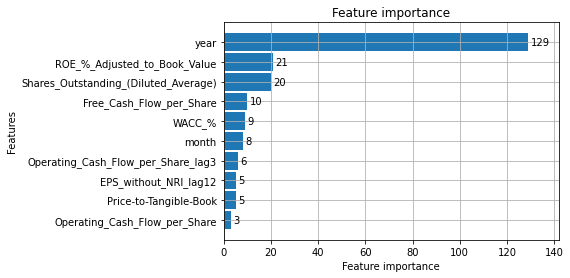

 95%|=================== | 15530/16313 [00:14<00:00]       

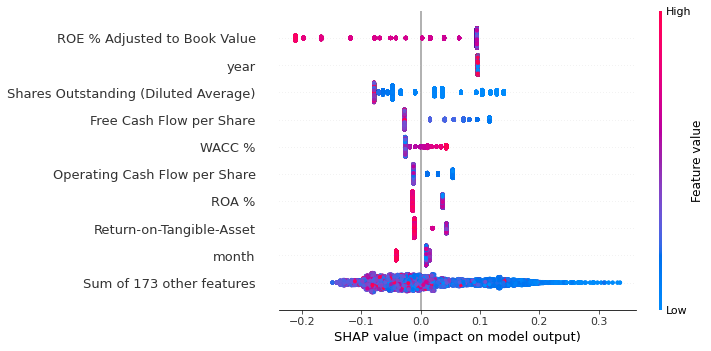

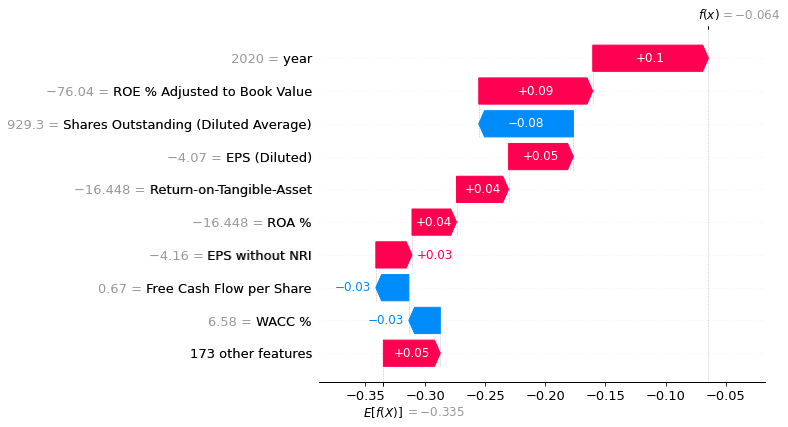

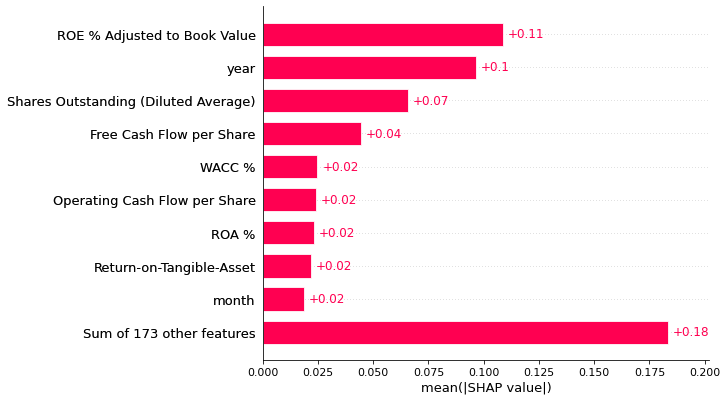

Eval target_less_-0.01_in_2_quart_along model


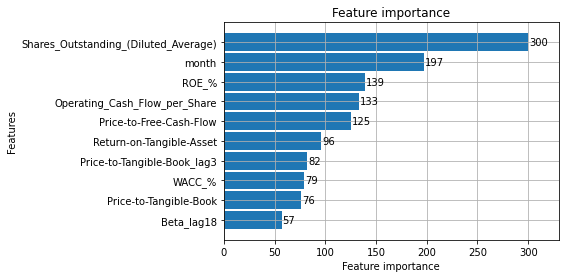

100%|===================| 15904/15938 [01:29<00:00]       

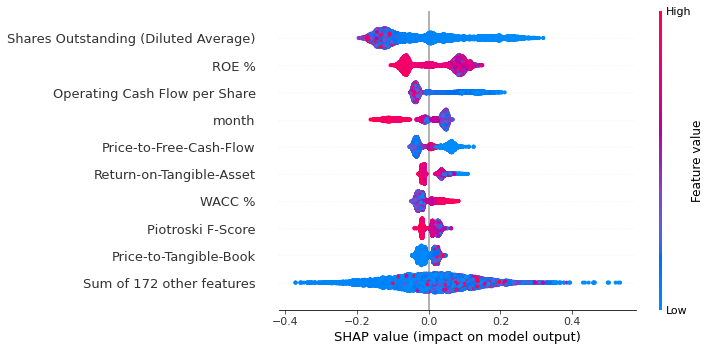

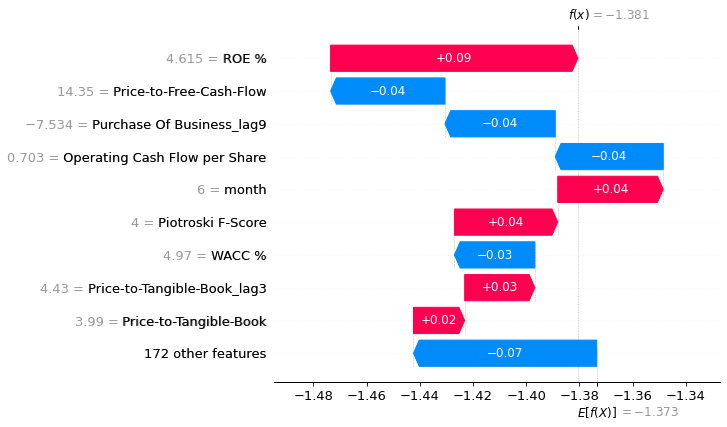

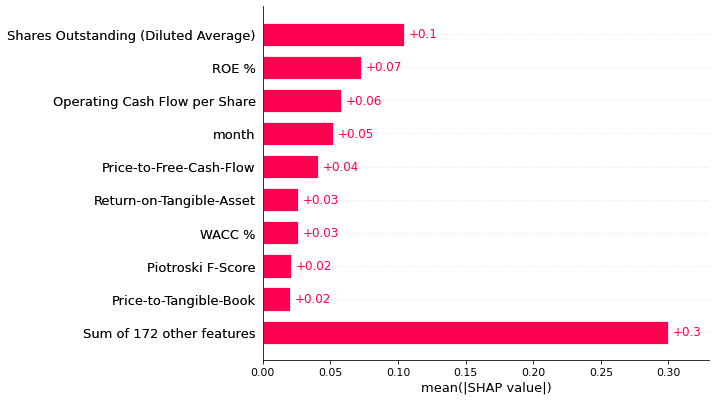

Eval target_less_-0.01_in_4_quart_along model


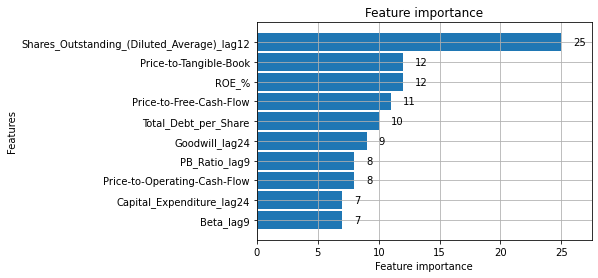

 94%|=================== | 14515/15488 [00:14<00:00]       

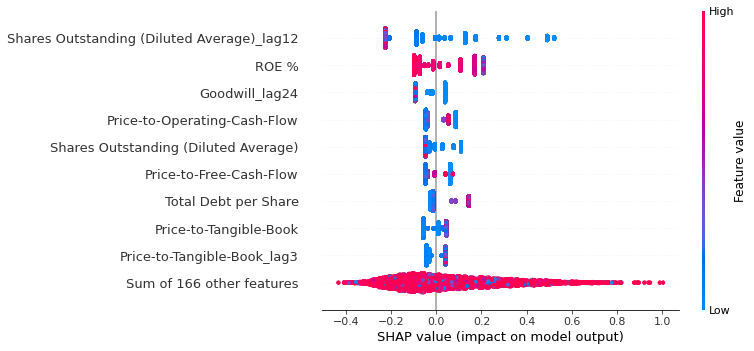

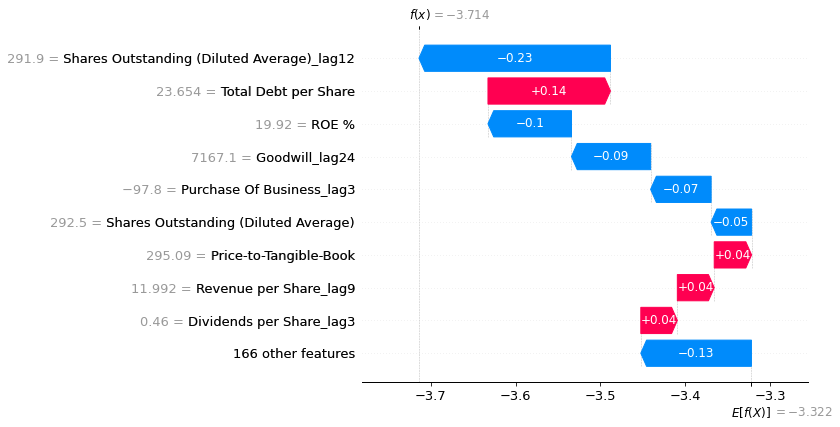

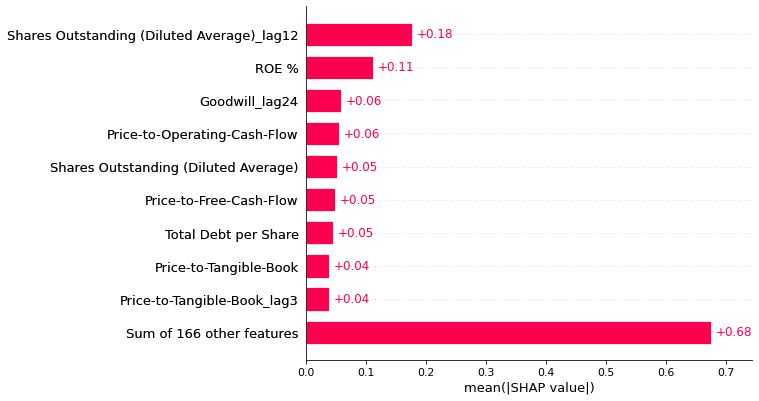

Eval target_less_-0.01_in_6_quart_along model


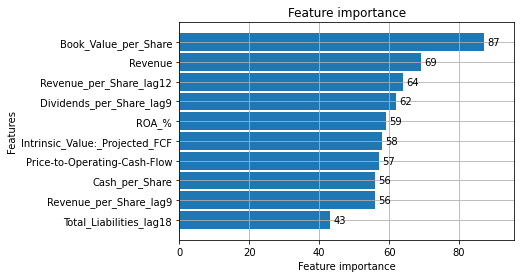

 99%|===================| 14965/15163 [00:36<00:00]       

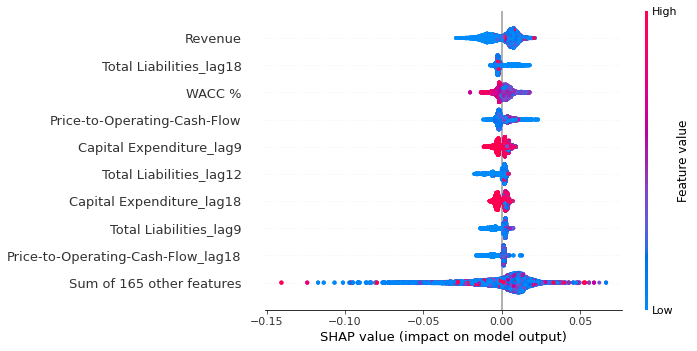

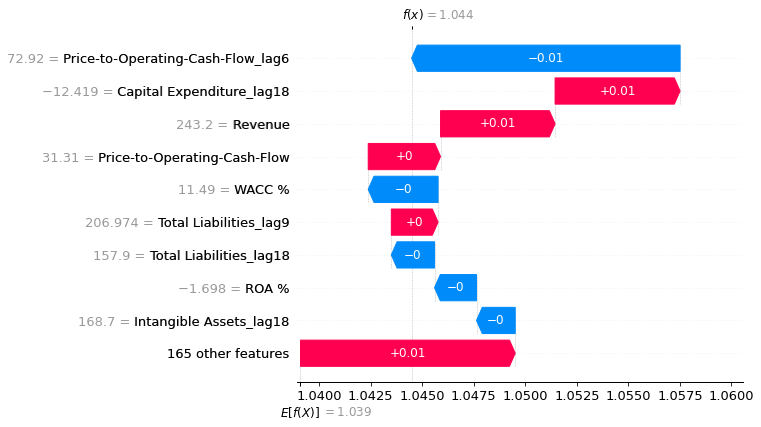

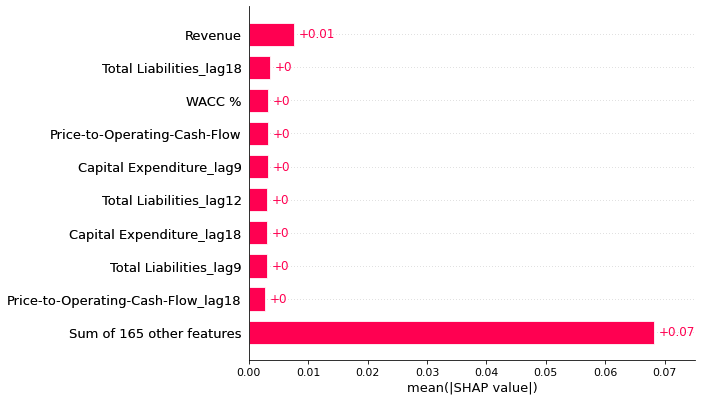

Eval target_less_-0.05_in_1_quart_along model


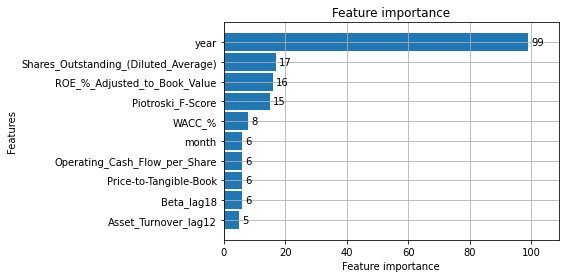

 95%|=================== | 15568/16313 [00:15<00:00]       

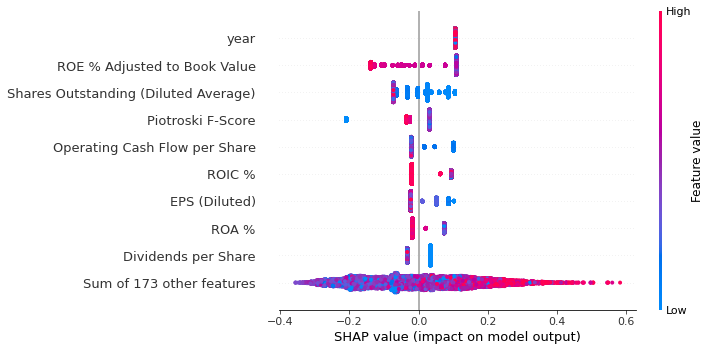

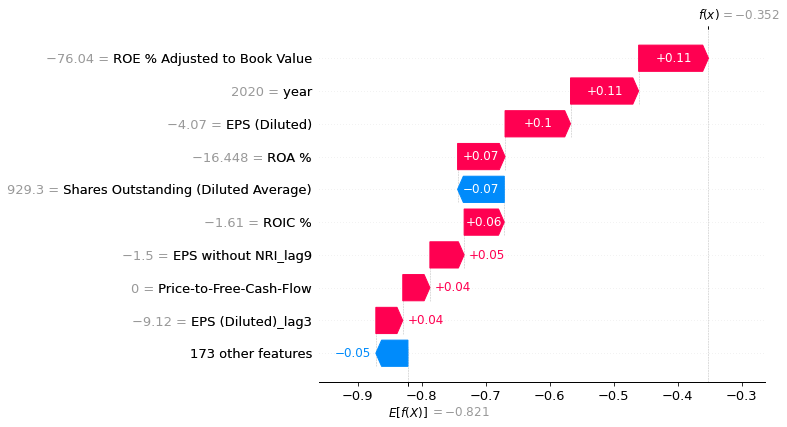

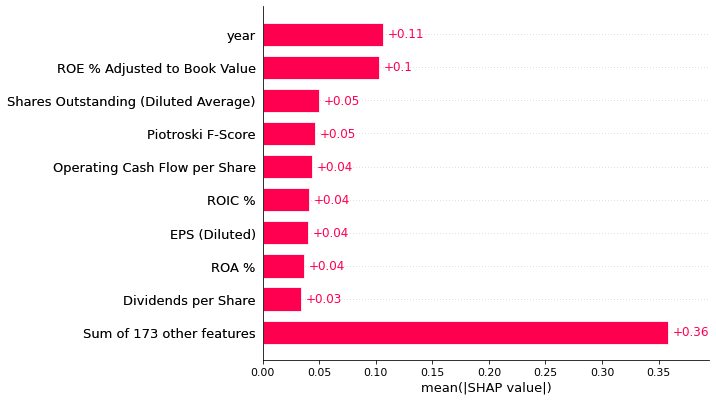

Eval target_less_-0.05_in_2_quart_along model


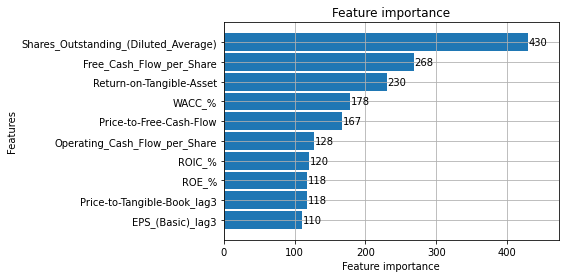

100%|===================| 15925/15938 [02:43<00:00]       

SHAP cannnot explane target_less_-0.05_in_2_quart_along
Eval target_less_-0.05_in_4_quart_along model


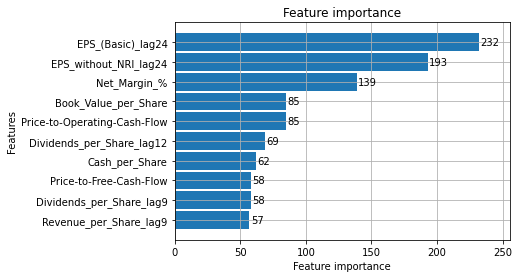

 99%|===================| 15311/15488 [01:04<00:00]       

SHAP cannnot explane target_less_-0.05_in_4_quart_along
Eval target_more_0.01_in_1_quart_along model


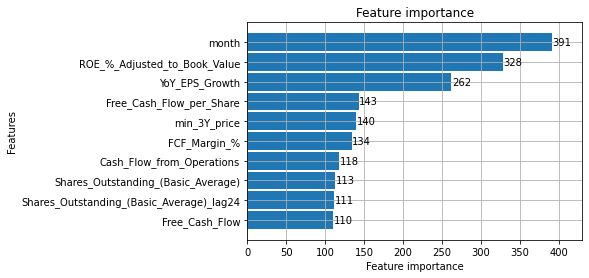

100%|===================| 16268/16313 [03:22<00:00]       

SHAP cannnot explane target_more_0.01_in_1_quart_along
Eval target_more_0.01_in_2_quart_along model


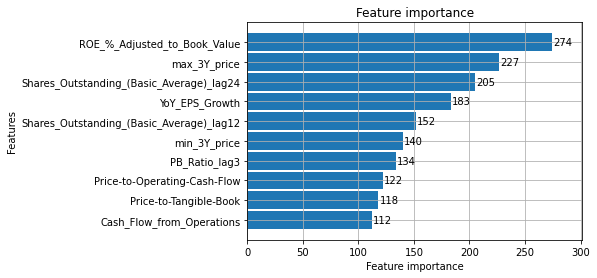

100%|===================| 15908/15938 [03:16<00:00]       

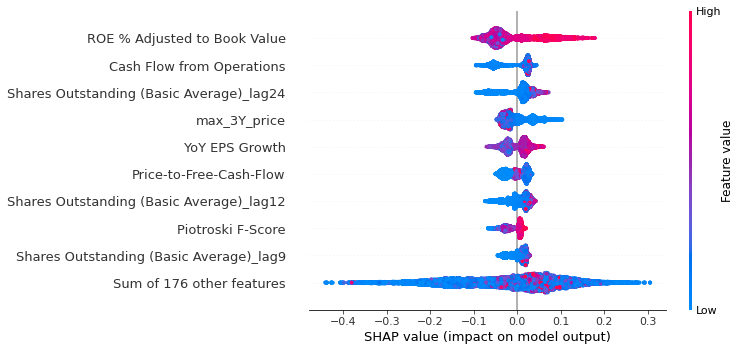

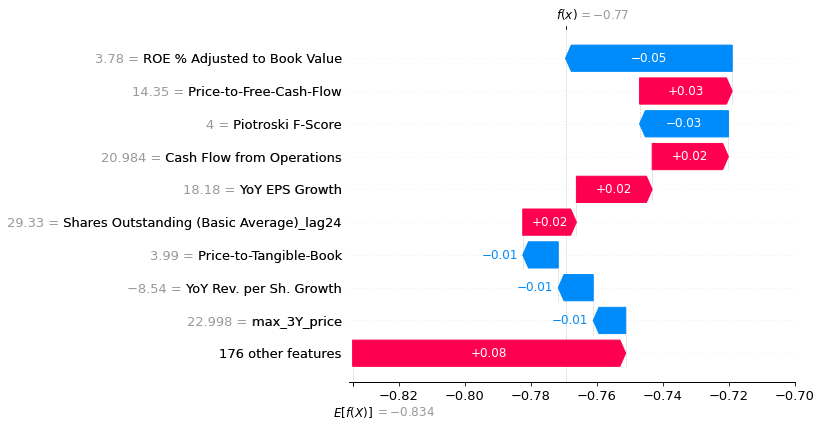

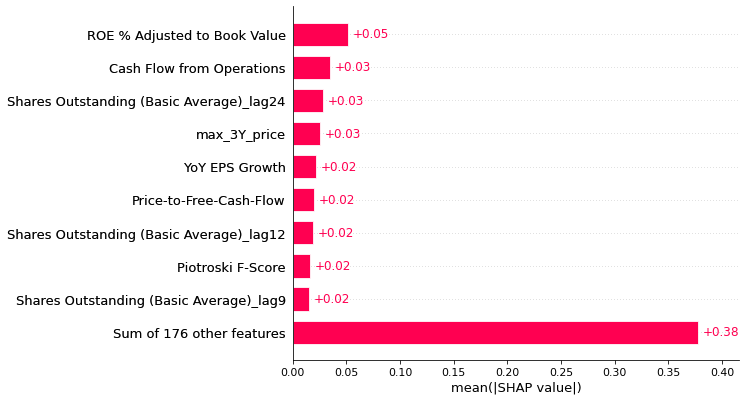

Eval target_more_0.01_in_4_quart_along model


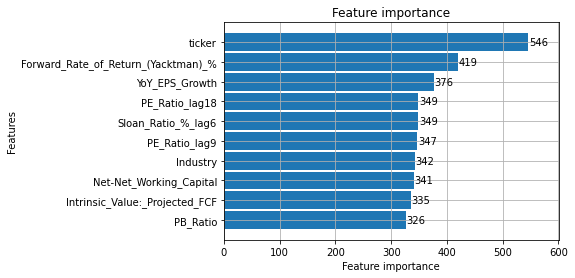

100%|===================| 15472/15488 [10:49<00:00]       

SHAP cannnot explane target_more_0.01_in_4_quart_along
Eval target_more_0.01_in_6_quart_along model


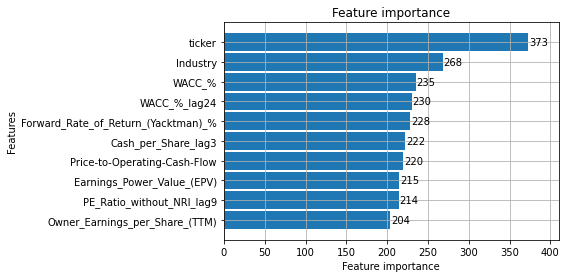

100%|===================| 15151/15163 [08:12<00:00]       

SHAP cannnot explane target_more_0.01_in_6_quart_along
Eval target_more_0.05_in_1_quart_along model


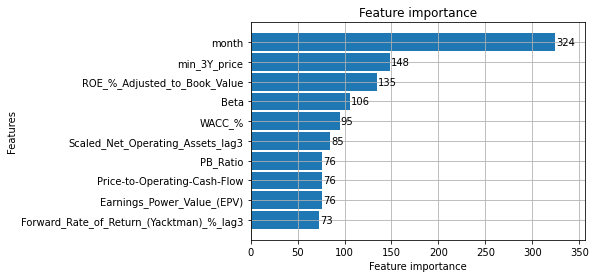

100%|===================| 16277/16313 [03:16<00:00]       

SHAP cannnot explane target_more_0.05_in_1_quart_along
Eval target_more_0.05_in_2_quart_along model


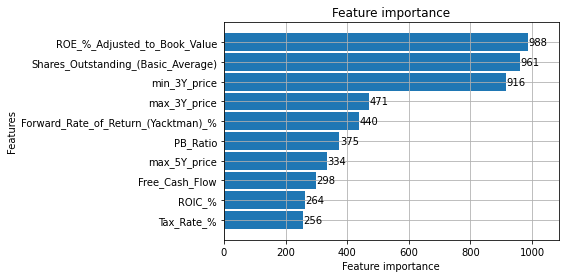

100%|===================| 15933/15938 [06:33<00:00]       

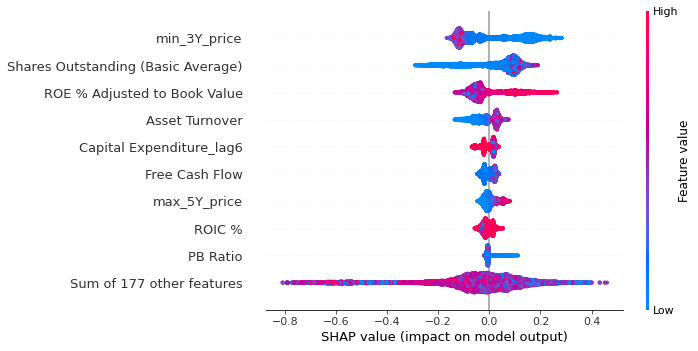

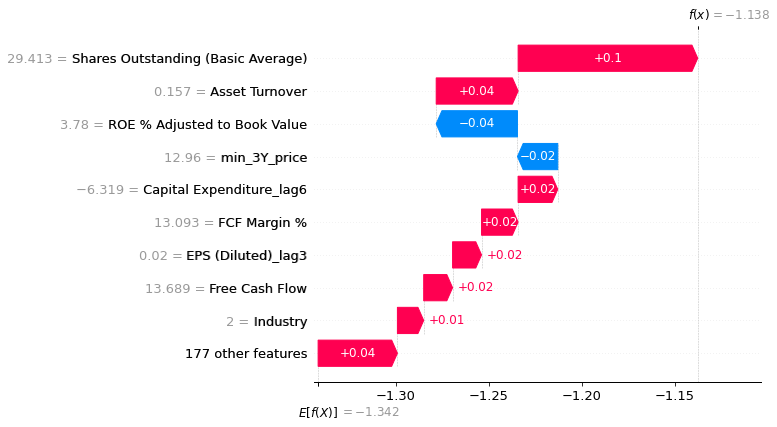

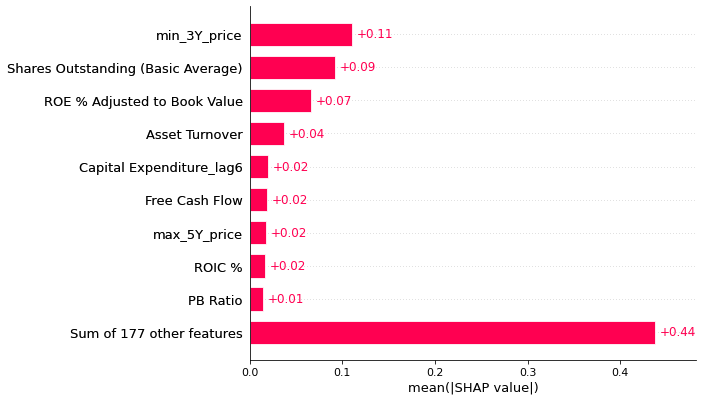

Eval target_more_0.05_in_4_quart_along model


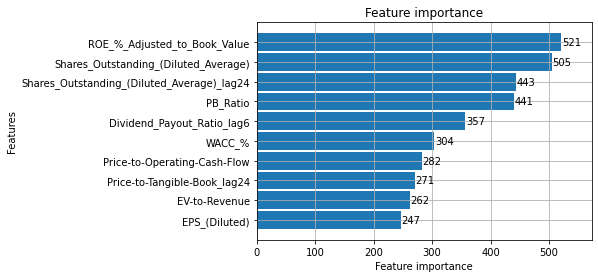

100%|===================| 15443/15488 [05:36<00:00]       

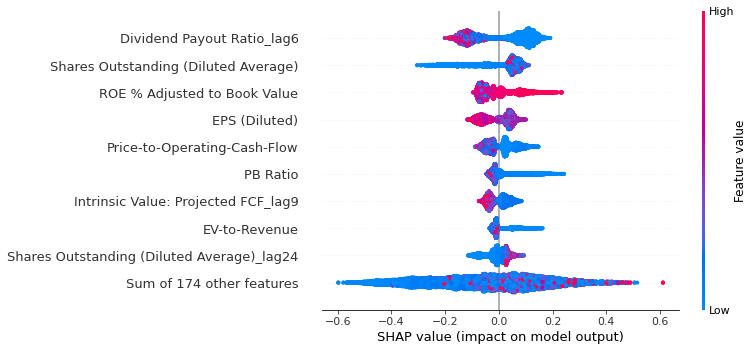

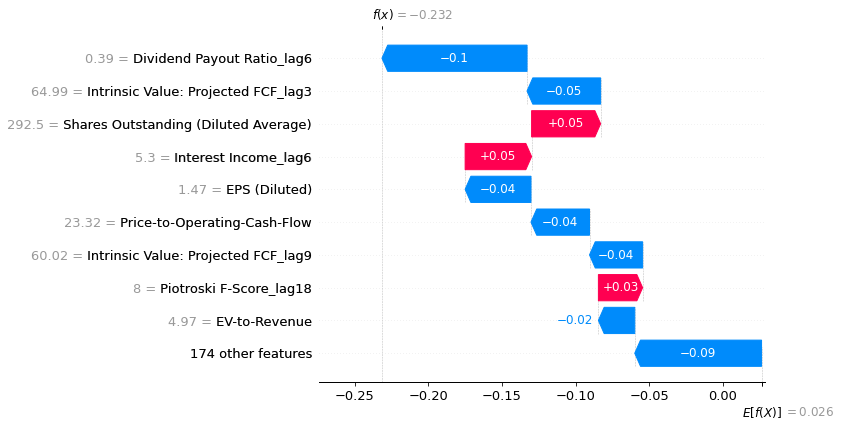

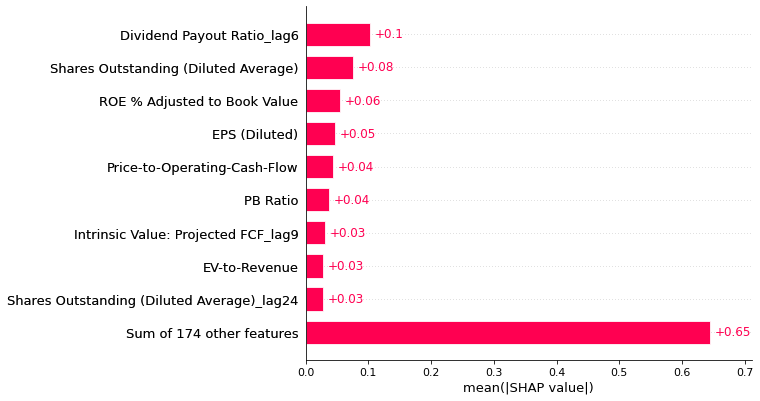

In [14]:
feature_ranking(df_gross)

In [ ]:
evaluation(df_gross)

Eval target_less_-0.01_in_1_quart_along model
[0.3081697434767307, 0.6540848717383654, 0.4904871825404907, 0.45670479830811067, 0.5807422178677435, 0.5013736263736264, 0.5219184763631647, 0.5306623058951417, 0.5298340089980739]
Eval target_less_-0.01_in_2_quart_along model
[0.44957075425041015, 0.7247853771252051, 0.32594556349167175, 0.23111801835650916, 0.6678776006171327, 0.22702991452991453, 0.2763703149931475, 0.2945549041141986, 0.2720510441981398]
Eval target_less_-0.01_in_4_quart_along model
[0.6383336888492811, 0.8191668444246406, 0.0662745332443057, 0.035297766198268875, 0.7917138885636413, 0.013354700854700854, 0.02726616554741555, 0.03101544804985432, 0.03385147496886735]
Eval target_less_-0.01_in_6_quart_along model
[-0.6330030972578785, 0.18349845137106077, 0.00250356108761563, 0.001259504451552731, 0.25555555555555554, 0.0, 0.0, 0.0, 0.0]
Eval target_less_-0.05_in_1_quart_along model
[0.4352557420846946, 0.7176278710423474, 0.46506547250597424, 0.39896815790389056, 0.646

In [ ]:
train_metrics = pd.read_csv('/content/drive/MyDrive/course_models/train_res.csv', index_col='Unnamed: 0')
test_metrics = pd.read_csv('/content/drive/MyDrive/course_models/oot_res.csv', index_col='Unnamed: 0')
last_year_metrics = pd.read_csv('/content/drive/MyDrive/course_models/last_year_res.csv', index_col='Unnamed: 0')


In [ ]:
train_metrics

gini   auc_roc        f1      prec  \
target_less_-0.01_in_1_quart_along  0.244607  0.622304  0.547975  0.511198   
target_less_-0.01_in_2_quart_along  0.297084  0.648542  0.372290  0.268071   
target_less_-0.01_in_4_quart_along  0.422858  0.711429  0.147575  0.083637   
target_less_-0.01_in_6_quart_along -0.517415  0.241292  0.008730  0.004447   
target_less_-0.05_in_1_quart_along  0.305635  0.652817  0.499465  0.426087   
target_less_-0.05_in_2_quart_along  0.397742  0.698871  0.303380  0.197804   
target_less_-0.05_in_4_quart_along  0.498092  0.749046  0.089803  0.048237   
target_more_0.01_in_1_quart_along   0.240952  0.620476  0.599705  0.602258   
target_more_0.01_in_2_quart_along   0.266012  0.633006  0.452862  0.359448   
target_more_0.01_in_4_quart_along   0.884696  0.942348  0.536973  0.387493   
target_more_0.01_in_6_quart_along   0.942142  0.971071  0.379539  0.239310   
target_more_0.05_in_1_quart_along   0.348899  0.674449  0.572063  0.529526   
target_more_0.05_in_2_quart_along   0.322267  0.661134  0.355267  0.247270   
target_more_0.05_in_4_quart_along   0.516350  0.758175  0.129529  0.071460   

                                         rec  
target_less_-0.01_in_1_quart_along  0.590455  
target_less_-0.01_in_2_quart_along  0.609088  
target_less_-0.01_in_4_quart_along  0.626537  
target_less_-0.01_in_6_quart_along  0.237288  
target_less_-0.05_in_1_quart_along  0.603375  
target_less_-0.05_in_2_quart_along  0.650668  
target_less_-0.05_in_4_quart_along  0.649315  
target_more_0.01_in_1_quart_along   0.597175  
target_more_0.01_in_2_quart_along   0.611879  
target_more_0.01_in_4_quart_along   0.874206  
target_more_0.01_in_6_quart_along   0.916696  
target_more_0.05_in_1_quart_along   0.622032  
target_more_0.05_in_2_quart_along   0.630750  
target_more_0.05_in_4_quart_along   0.691198

In [ ]:
test_metrics

gini   auc_roc        f1      prec  \
target_less_-0.01_in_1_quart_along  0.316127  0.658063  0.504627  0.461456   
target_less_-0.01_in_2_quart_along  0.465220  0.732610  0.340267  0.223349   
target_less_-0.01_in_4_quart_along  0.594559  0.797279  0.061027  0.031791   
target_less_-0.01_in_6_quart_along -0.660292  0.169854  0.001009  0.000505   
target_less_-0.05_in_1_quart_along  0.419298  0.709649  0.492269  0.384315   
target_less_-0.05_in_2_quart_along  0.558856  0.779428  0.301270  0.191847   
target_less_-0.05_in_4_quart_along  0.726885  0.863443  0.049358  0.025458   
target_more_0.01_in_1_quart_along   0.284376  0.642188  0.675336  0.708836   
target_more_0.01_in_2_quart_along   0.259952  0.629976  0.576989  0.520038   
target_more_0.01_in_4_quart_along   0.255788  0.627894  0.322367  0.216431   
target_more_0.01_in_6_quart_along   0.240882  0.620441  0.065377  0.034826   
target_more_0.05_in_1_quart_along   0.332572  0.666286  0.624589  0.626191   
target_more_0.05_in_2_quart_along   0.203975  0.601988  0.451440  0.362289   
target_more_0.05_in_4_quart_along   0.281046  0.640523  0.203693  0.119437   

                                         rec  
target_less_-0.01_in_1_quart_along  0.556711  
target_less_-0.01_in_2_quart_along  0.714062  
target_less_-0.01_in_4_quart_along  0.759259  
target_less_-0.01_in_6_quart_along  0.285714  
target_less_-0.05_in_1_quart_along  0.684564  
target_less_-0.05_in_2_quart_along  0.701229  
target_less_-0.05_in_4_quart_along  0.806452  
target_more_0.01_in_1_quart_along   0.644859  
target_more_0.01_in_2_quart_along   0.647948  
target_more_0.01_in_4_quart_along   0.631434  
target_more_0.01_in_6_quart_along   0.532609  
target_more_0.05_in_1_quart_along   0.622995  
target_more_0.05_in_2_quart_along   0.598786  
target_more_0.05_in_4_quart_along   0.691538

In [ ]:
last_year_metrics

gini   auc_roc        f1      prec  \
target_less_-0.01_in_1_quart_along  0.308170  0.654085  0.490487  0.456705   
target_less_-0.01_in_2_quart_along  0.449571  0.724785  0.325946  0.231118   
target_less_-0.01_in_4_quart_along  0.638334  0.819167  0.066275  0.035298   
target_less_-0.01_in_6_quart_along -0.633003  0.183498  0.002504  0.001260   
target_less_-0.05_in_1_quart_along  0.435256  0.717628  0.465065  0.398968   
target_less_-0.05_in_2_quart_along  0.581292  0.790646  0.283038  0.188723   
target_less_-0.05_in_4_quart_along  0.761276  0.880638  0.054422  0.028244   
target_more_0.01_in_1_quart_along   0.258988  0.629494  0.656374  0.708352   
target_more_0.01_in_2_quart_along   0.267400  0.633700  0.561096  0.523194   
target_more_0.01_in_4_quart_along   0.243391  0.621696  0.294125  0.208803   
target_more_0.01_in_6_quart_along   0.362005  0.681003  0.063142  0.035441   
target_more_0.05_in_1_quart_along   0.261727  0.630864  0.576797  0.594064   
target_more_0.05_in_2_quart_along   0.192132  0.596066  0.418792  0.367033   
target_more_0.05_in_4_quart_along   0.309346  0.654673  0.192963  0.119163   

                                         rec  accuracy_top_1%  \
target_less_-0.01_in_1_quart_along  0.580742         0.501374   
target_less_-0.01_in_2_quart_along  0.667878         0.227030   
target_less_-0.01_in_4_quart_along  0.791714         0.013355   
target_less_-0.01_in_6_quart_along  0.255556         0.000000   
target_less_-0.05_in_1_quart_along  0.646058         0.495421   
target_less_-0.05_in_2_quart_along  0.739140         0.161859   
target_less_-0.05_in_4_quart_along  0.847961         0.059441   
target_more_0.01_in_1_quart_along   0.638133         0.762821   
target_more_0.01_in_2_quart_along   0.641407         0.556624   
target_more_0.01_in_4_quart_along   0.622047         0.297009   
target_more_0.01_in_6_quart_along   0.632276         0.027778   
target_more_0.05_in_1_quart_along   0.591610         0.734890   
target_more_0.05_in_2_quart_along   0.568408         0.598825   
target_more_0.05_in_4_quart_along   0.704623         0.176282   

                                    accuracy_top_3%  accuracy_top_5%  \
target_less_-0.01_in_1_quart_along         0.521918         0.530662   
target_less_-0.01_in_2_quart_along         0.276370         0.294555   
target_less_-0.01_in_4_quart_along         0.027266         0.031015   
target_less_-0.01_in_6_quart_along         0.000000         0.000000   
target_less_-0.05_in_1_quart_along         0.493261         0.477193   
target_less_-0.05_in_2_quart_along         0.245338         0.257293   
target_less_-0.05_in_4_quart_along         0.035338         0.031693   
target_more_0.01_in_1_quart_along          0.775998         0.755964   
target_more_0.01_in_2_quart_along          0.549426         0.540071   
target_more_0.01_in_4_quart_along          0.260686         0.229485   
target_more_0.01_in_6_quart_along          0.046267         0.044616   
target_more_0.05_in_1_quart_along          0.688332         0.660265   
target_more_0.05_in_2_quart_along          0.441079         0.416706   
target_more_0.05_in_4_quart_along          0.125944         0.134541   

                                    accuracy_top_10%  
target_less_-0.01_in_1_quart_along          0.529834  
target_less_-0.01_in_2_quart_along          0.272051  
target_less_-0.01_in_4_quart_along          0.033851  
target_less_-0.01_in_6_quart_along          0.000000  
target_less_-0.05_in_1_quart_along          0.470630  
target_less_-0.05_in_2_quart_along          0.222376  
target_less_-0.05_in_4_quart_along          0.027103  
target_more_0.01_in_1_quart_along           0.725310  
target_more_0.01_in_2_quart_along           0.529862  
target_more_0.01_in_4_quart_along           0.219341  
target_more_0.01_in_6_quart_along           0.036544  
target_more_0.05_in_1_quart_along           0.638207  
target_more_0.05_in_2_quart_along           0.394524  
target_more_0.05_in_4_quart_along         

In [11]:
financial_evaluation(df_gross)

Eval target_less_-0.01_in_1_quart_along model
Horiz = 1
Eval target_less_-0.01_in_2_quart_along model
Horiz = 2
Eval target_less_-0.01_in_4_quart_along model
Horiz = 4
Eval target_less_-0.01_in_6_quart_along model
Horiz = 6
Eval target_less_-0.05_in_1_quart_along model
Horiz = 1
Eval target_less_-0.05_in_2_quart_along model
Horiz = 2
Eval target_less_-0.05_in_4_quart_along model
Horiz = 4
Eval target_more_0.01_in_1_quart_along model
Horiz = 1
Eval target_more_0.01_in_2_quart_along model
Horiz = 2
Eval target_more_0.01_in_4_quart_along model
Horiz = 4
Eval target_more_0.01_in_6_quart_along model
Horiz = 6
Eval target_more_0.05_in_1_quart_along model
Horiz = 1
Eval target_more_0.05_in_2_quart_along model
Horiz = 2
Eval target_more_0.05_in_4_quart_along model
Horiz = 4


In [14]:
first_month, last_month, avg_monthly = summary_fin_eval(df_gross)

Extract from target_less_-0.01_in_1_quart_along fin. results
Extract from target_less_-0.01_in_2_quart_along fin. results
Extract from target_less_-0.01_in_4_quart_along fin. results
Extract from target_less_-0.01_in_6_quart_along fin. results
Extract from target_less_-0.05_in_1_quart_along fin. results
Extract from target_less_-0.05_in_2_quart_along fin. results
Extract from target_less_-0.05_in_4_quart_along fin. results
Extract from target_more_0.01_in_1_quart_along fin. results
Extract from target_more_0.01_in_2_quart_along fin. results
Extract from target_more_0.01_in_4_quart_along fin. results
Extract from target_more_0.01_in_6_quart_along fin. results
Extract from target_more_0.05_in_1_quart_along fin. results
Extract from target_more_0.05_in_2_quart_along fin. results
Extract from target_more_0.05_in_4_quart_along fin. results


In [22]:
first_month['period'] = pd.to_datetime(first_month['period'])
first_month

target     period  return_top_1%  \
0  target_less_-0.01_in_1_quart_along 2019-06-01      -0.392000   
0  target_less_-0.01_in_2_quart_along 2019-06-01      -0.675214   
0  target_less_-0.01_in_4_quart_along 2019-06-01      -0.622163   
0  target_less_-0.01_in_6_quart_along 2019-06-01       0.336985   
0  target_less_-0.05_in_1_quart_along 2019-06-01      -0.414312   
0  target_less_-0.05_in_2_quart_along 2019-06-01      -0.721364   
0  target_less_-0.05_in_4_quart_along 2019-06-01      -0.806892   
0   target_more_0.01_in_1_quart_along 2019-06-01       0.070737   
0   target_more_0.01_in_2_quart_along 2019-06-01       0.348312   
0   target_more_0.01_in_4_quart_along 2019-06-01       1.634024   
0   target_more_0.01_in_6_quart_along 2019-06-01       0.266639   
0   target_more_0.05_in_1_quart_along 2019-06-01       0.298927   
0   target_more_0.05_in_2_quart_along 2019-06-01       0.445758   
0   target_more_0.05_in_4_quart_along 2019-06-01       0.410110   

   return_top_3%  return_top_5%  return_top_10%  
0      -0.279986      -0.235296       -0.161496  
0      -0.574129      -0.449505       -0.295523  
0      -0.491936      -0.346831       -0.047627  
0       0.233461       0.266351        0.317750  
0      -0.293719      -0.216216       -0.148515  
0      -0.592921      -0.482696       -0.233127  
0      -0.558455      -0.387666       -0.082399  
0       0.055614       0.065912        0.047455  
0       0.196077       0.143599        0.137406  
0       1.079360       0.936668        0.615648  
0       0.349022       0.323837        0.362933  
0       0.190813       0.170708        0.137833  
0       0.281354       0.185292        0.165947  
0       0.329834       0.160149        0.127235

In [19]:
last_month['period'] = pd.to_datetime(last_month['period'])
last_month

target     period  return_top_1%  \
11  target_less_-0.01_in_1_quart_along 2020-05-01       0.099084   
11  target_less_-0.01_in_2_quart_along 2020-05-01       0.137913   
11  target_less_-0.01_in_4_quart_along 2020-05-01       0.795836   
11  target_less_-0.01_in_6_quart_along 2020-05-01       3.275187   
11  target_less_-0.05_in_1_quart_along 2020-05-01       0.187008   
11  target_less_-0.05_in_2_quart_along 2020-05-01       0.048022   
11  target_less_-0.05_in_4_quart_along 2020-05-01       0.215451   
11   target_more_0.01_in_1_quart_along 2020-05-01       0.420080   
11   target_more_0.01_in_2_quart_along 2020-05-01       0.551911   
11   target_more_0.01_in_4_quart_along 2020-05-01       0.996435   
11   target_more_0.01_in_6_quart_along 2020-05-01       0.630574   
11   target_more_0.05_in_1_quart_along 2020-05-01       0.824716   
11   target_more_0.05_in_2_quart_along 2020-05-01       1.561572   
11   target_more_0.05_in_4_quart_along 2020-05-01       1.595432   

    return_top_3%  return_top_5%  return_top_10%  
11       0.483352       0.496756        0.334829  
11       0.371340       0.295298        0.313966  
11       0.423663       0.536360        0.780056  
11       1.989636       1.611007        1.348693  
11       0.533196       0.435485        0.404924  
11       0.363988       0.306580        0.346898  
11       0.551935       0.474956        0.718349  
11       0.269891       0.214697        0.201816  
11       0.359206       0.367123        0.410658  
11       0.927356       0.932863        0.887870  
11       0.718315       1.109988        1.092010  
11       0.543931       0.456763        0.372725  
11       0.966316       0.867619        0.704463  
11       1.836494       1.590695        1.610661

In [21]:
avg_monthly

target    period  return_top_1%  \
12  target_less_-0.01_in_1_quart_along  avg_year      -0.227691   
12  target_less_-0.01_in_2_quart_along  avg_year      -0.286860   
12  target_less_-0.01_in_4_quart_along  avg_year       0.245109   
12  target_less_-0.01_in_6_quart_along  avg_year       1.144956   
12  target_less_-0.05_in_1_quart_along  avg_year      -0.187675   
12  target_less_-0.05_in_2_quart_along  avg_year      -0.280203   
12  target_less_-0.05_in_4_quart_along  avg_year      -0.006009   
12   target_more_0.01_in_1_quart_along  avg_year       0.112874   
12   target_more_0.01_in_2_quart_along  avg_year       0.203642   
12   target_more_0.01_in_4_quart_along  avg_year       1.344369   
12   target_more_0.01_in_6_quart_along  avg_year       0.458785   
12   target_more_0.05_in_1_quart_along  avg_year       0.241255   
12   target_more_0.05_in_2_quart_along  avg_year       0.559113   
12   target_more_0.05_in_4_quart_along  avg_year       1.206376   

    return_top_3%  return_top_5%  return_top_10%  
12      -0.007704       0.023427        0.031112  
12       0.011255       0.048850        0.086137  
12       0.254320       0.511365        0.708727  
12       1.097343       0.927487        0.804081  
12       0.011176       0.003868        0.056970  
12      -0.041367       0.040908        0.129858  
12       0.287513       0.289900        0.708279  
12       0.079095       0.049730        0.037481  
12       0.083378       0.058206        0.059116  
12       1.045740       0.914917        0.766443  
12       0.559213       0.707480        0.716059  
12       0.201093       0.145844        0.126994  
12       0.306075       0.297959        0.258494  
12       1.208580       1.020108        1.063809